## 轉換資料型態

# 固定亂數

In [1]:
import torch
import numpy as np
import random

def set_seeds(seed):
    random.seed(seed)  # 設定 Python 標準庫的亂數生成器種子
    np.random.seed(seed)  # 設定 NumPy 亂數生成器種子
    torch.manual_seed(seed)  # 設定 PyTorch 的 CPU 亂數生成器種子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設定 PyTorch 在單個 GPU 上的亂數種子
        torch.cuda.manual_seed_all(seed)  # 設定 PyTorch 在所有 GPU 上的亂數種子
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基準測試功能
    torch.backends.cudnn.deterministic = True  # 強制 cuDNN 使用確定性算法

set_seeds(2526)

In [2]:
from transformers import BitsAndBytesConfig
# 設定 4-bit 量化參數
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(
    'openai/whisper-large-v3-turbo',
    predict_timestamps=False,
    task="transcribe",
    language='zh'
)

In [4]:
from transformers import AutoModelForSpeechSeq2Seq

base_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    'openai/whisper-large-v3-turbo',
    quantization_config=quant_config,
    torch_dtype=torch.float16,
    use_cache=False
)

print(base_model)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear4bit(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear4bit(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear4bit(in_features=5120

In [5]:
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

# 建立 LoRA 配置
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias='none',
    target_modules=['q_proj', 'v_proj']
)

# 準備模型支援量化訓練
base_model = prepare_model_for_kbit_training(base_model, use_gradient_checkpointing=False)

# 加入 LoRA 模型
model = get_peft_model(base_model, lora_config)


In [6]:
import os
import pandas as pd
import librosa
from tqdm import tqdm

def load_dataset(audio_dir, transcript_file='ASR_CN.csv', target_sr=16000):
    df = pd.read_csv(transcript_file, encoding='utf-8-sig')
    df['path'] = df['ID'].apply(lambda x: os.path.join(audio_dir, x))

    print(f'>>> 共有 {len(df)} 筆紀錄，開始載入音訊...')

    audio_list = []
    sentence_list = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="載入音訊中", unit="記錄"):
        wav_path = row['path']
        sentence = row.get('sentence', '').strip()
        audio, sr = librosa.load(wav_path, sr=target_sr, mono=True)

        audio_list.append(audio)
        sentence_list.append(sentence)

    return audio_list, sentence_list

audios, sentences = load_dataset('audio', 'ASR_CN.csv', target_sr=16000)

>>> 共有 1000 筆紀錄，開始載入音訊...


載入音訊中: 100%|██████████| 1000/1000 [00:05<00:00, 168.28記錄/s]


In [7]:
def extract_features(audio_list, processor, sampling_rate):
    feat = processor.feature_extractor(
        audio_list,
        sampling_rate=sampling_rate,
        return_tensors='pt',
        return_attention_mask=True,
        padding='max_length',
        max_length=sampling_rate * 30,  # 最長30秒
        truncation=True
    )
    return feat['input_features'], feat['attention_mask']


input_features, attention_mask = extract_features(audios, processor, sampling_rate=16000)

In [8]:
from torch.utils.data import Dataset, DataLoader

class SpeechSeq2SeqDataset(Dataset):

    def __init__(self, input_features, attention_masks, sentences, processor):
        assert len(input_features) == len(attention_masks) == len(sentences)
        self.input_features = input_features
        self.attention_masks = attention_masks
        self.sentences = sentences
        self.processor = processor

    def __len__(self):
        return len(self.input_features)

    def __getitem__(self, idx):
        return {
            "input_features": self.input_features[idx],
            "attention_mask": self.attention_masks[idx],
            "sentence": self.sentences[idx],
        }

    def collate_fn(self, batch):
        input_feats = torch.stack([item['input_features'] for item in batch])
        attention_masks = torch.stack([item['attention_mask'] for item in batch])
        sentences = [item['sentence'] for item in batch]

        # 處理 target：tokenizer 編碼句子
        tok = self.processor.tokenizer(
            sentences,
            padding=True,
            return_tensors='pt',
            return_attention_mask=True
        )

        # 對非 padding 的部分保留，其他設為 -100 以供 loss 使用
        labels = tok['input_ids'].masked_fill(tok['attention_mask'].ne(1), -100)

        return {
            'input_features': input_feats,
            'attention_mask': attention_masks,
            'labels': labels
        }


from sklearn.model_selection import train_test_split

# 拆分資料
feat_train, feat_valid, attn_train, attn_valid, sent_train, sent_valid = train_test_split(
    input_features, attention_mask, sentences, train_size=0.8, random_state=2526, shuffle=True
)

# 建立 Dataset
train_dataset = SpeechSeq2SeqDataset(feat_train, attn_train, sent_train, processor)
valid_dataset = SpeechSeq2SeqDataset(feat_valid, attn_valid, sent_valid, processor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=valid_dataset.collate_fn)


Using device: cuda


Valid Epoch 0: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s, loss=0.675]


Saving Model With Loss 0.55196
Train Loss: 1.02480 | Valid Loss: 0.55196 | Best Loss: 0.55196



Valid Epoch 1: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s, loss=0.580]


Saving Model With Loss 0.52033
Train Loss: 0.46845 | Valid Loss: 0.52033 | Best Loss: 0.52033



Valid Epoch 2: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s, loss=0.570]


Saving Model With Loss 0.51839
Train Loss: 0.38862 | Valid Loss: 0.51839 | Best Loss: 0.51839



Valid Epoch 3: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s, loss=0.559]


Train Loss: 0.33530 | Valid Loss: 0.52510 | Best Loss: 0.51839



Valid Epoch 4: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s, loss=0.563]


Train Loss: 0.29135 | Valid Loss: 0.54468 | Best Loss: 0.51839



Valid Epoch 5: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s, loss=0.611]


Train Loss: 0.24830 | Valid Loss: 0.54996 | Best Loss: 0.51839



Valid Epoch 6: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s, loss=0.600]


Train Loss: 0.21451 | Valid Loss: 0.56744 | Best Loss: 0.51839



Valid Epoch 7: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s, loss=0.601]


Train Loss: 0.18471 | Valid Loss: 0.58050 | Best Loss: 0.51839

--------------------------------------
| Model can't improve, stop training |
--------------------------------------


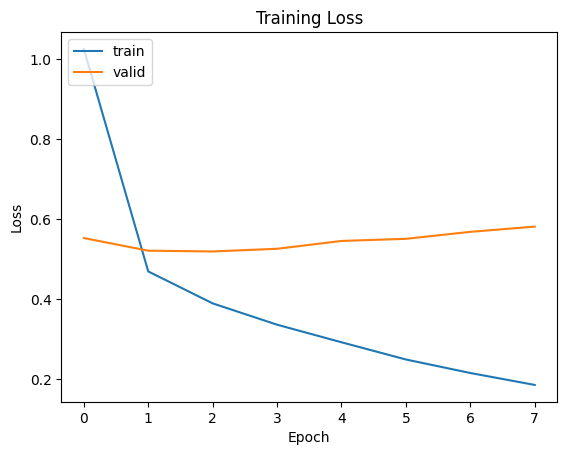

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Best LoRA model loaded from ./checkpoints


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\peft\peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.encoder.layers.1.self_attn.v_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.encoder.layers.1.self_attn.v_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.encoder.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.encoder.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.

In [9]:
from Trainer import Trainer
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup

# 總步數 = epoch 數 * 每個 epoch 的 batch 數
num_training_steps = len(train_loader) * 100  # 100 是總 epoch 數
num_warmup_steps = int(0.2 * len(train_loader))  # 可調整 warmup 比例

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)
trainer = Trainer(
    epochs=100,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stopping=5,
    load_best_model=True,
    grad_clip=1.0,
    is_lora=True
)

trainer.train(show_loss=True)

In [10]:
from jiwer import cer

def evaluate_cer_with_whisper(valid_dataloader, model, processor, device="auto"):
    # 自動選擇運算裝置
    if device == "auto":    
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用裝置：{device}")
    model = model.to(device)

    total_chars = 0
    total_errors = 0

    for input_datas in tqdm(valid_dataloader, desc="Evaluating CER"):
        input_datas = {k: v.to(device) for k, v in input_datas.items()} # 將資料移動到GPU上

        labels = input_datas["labels"]

        # 產生模型輸出
        predicted_ids = model.generate(**input_datas)

        # 解碼模型預測結果與 ground truth
        hyp = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0].strip()
        truth = processor.batch_decode(labels, skip_special_tokens=True)[0].strip()

        # 計算 CER
        cur_cer = cer(truth, hyp)
        total_chars += len(truth)
        total_errors += cur_cer * len(truth)
        
    average_cer = total_errors / total_chars if total_chars > 0 else 0
    print(f"\n✅ 平均 CER: {average_cer:.2%}")
    return average_cer

# 呼叫時要傳入 processor
evaluate_cer_with_whisper(valid_loader, model, processor, device="auto")


使用裝置：cuda


Evaluating CER: 100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


✅ 平均 CER: 47.28%


0.4728323699421965